# Generate Random Art with a Neural Network #
### Tuan Le ###
### tuanle@hotmail.de###

## Motivation##
This notebook has the purpose to show how a neural network can generate random colour or black-white images.  
The main idea was taken from David Ha's [blogpost](http://blog.otoro.net/2015/06/19/neural-network-generative-art/) creating random art by a neural net using Andrej Karpathy's [recurrent.js](https://github.com/karpathy/recurrentjs) javascript library.    
  
This implementation is in pure python NumPy and explains how the generation of images works.  
When training a neural network random, weights matrices $\mathbf{W_i}, i=1,...,n_l + 1$ will be initialized where $n_l$ is the number of hidden layers of the neural network.  
In this implementation, the weights will be initialized by drawing from a [standard normal distribution](http://mathworld.wolfram.com/StandardNormalDistribution.html) $\mathcal{N}(\mu=0, \sigma^2=1)$ as depicted in the code below. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

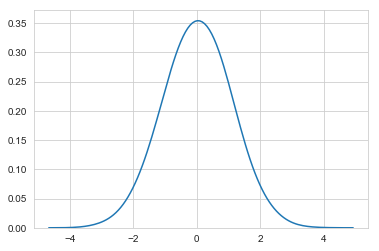

In [2]:
### Draw a large vector of random numbers by standard normal distribution
random_numbers = np.random.normal(loc=0.0, scale=1.0, size=2000)
### Now suppose we wanted to approximate the density function of those random numbers, we suppose
### the kernel density estimate to look like the standard normal distribution
sns.set_style("whitegrid")
sns.kdeplot(random_numbers, bw=0.5)

## How the Random Art Algorithm works ##

A neural network is mostly used as classification or regression model.  
Suppose we have some input data $\mathbf{x_i}$ and want to predict the outcome $\mathbf{y_i}$ where $\mathbf{x_i}$ is a vector of dimension $p$ and $\mathbf{y_i}$ a vector of dimension $k$.  
In this case we have a classification problem predicting one of the possible classes $k$.  
  
For the art generation, depending on which *colormode* we want to select ([classic RGB](https://en.wikipedia.org/wiki/RGB_color_model), [Grayscale](https://en.wikipedia.org/wiki/Grayscale), [CMYK](https://en.wikipedia.org/wiki/CMYK_color_model) and [HSL or HSV](https://en.wikipedia.org/wiki/HSL_and_HSV)), in the **output-layer** we have either 3,1,4 or 3 **output-neurons**.  
Since (for float) those colour-values are in the range $[0,1]$ the weigted input to each output-neuron will be transformed with a [sigmoid activation function](http://mathworld.wolfram.com/SigmoidFunction.html) as depicted below.

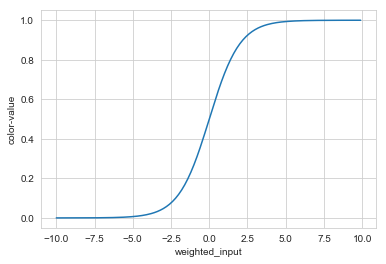

In [3]:
x = np.arange(-10, 10, 0.1)
sigmoid = 1 / (1 + np.exp(-x))
plt.plot(x, sigmoid)
plt.xlabel("weighted_input")
plt.ylabel("color-value")
plt.show()

For the hidden layer activations one can select different [activation functions](https://en.wikipedia.org/wiki/Activation_function) but since we map the `weighted_input` via sigmoid and want to create a variety range of colour-values between approx. 0.25 and 0.75, for each hidden layer the [tanh activation](http://mathworld.wolfram.com/HyperbolicTangent.html) will be used as depicted below. Note that this implementation by default selects those activation functions. I wrote a `NeuralNet`-class which can select different hidden layer neurons and layer activations (but for the output layer make sure the activation functions maps into range $[0,1]$) through the input paramter-lists `layers_dims` and `activations_fnc`.  

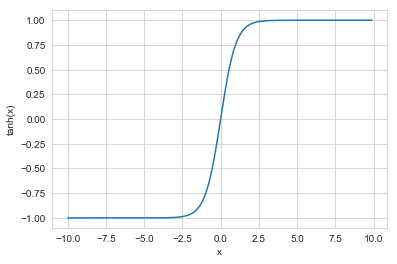

In [4]:
x = np.arange(-10, 10, 0.1)
tanh = np.tanh(x)
plt.plot(x, tanh)
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.show()

The algorithm also incorporates the [alpha channel](https://en.wikipedia.org/wiki/Alpha_compositing) which determines the degree of transparency and opacity. When a color (source) is blended with another color (background), e.g., when an image is overlaid onto another image, the alpha value of the source color is used to determine the resulting color. If the alpha value is opaque, the source color overwrites the destination color; if transparent, the source color is invisible, allowing the background color to show through. If the value is in between, the resulting color has a varying degree of transparency/opacity, which creates a translucent effect. 

The color-values in the output layer will be generated by computing a **forward-pass** of input data. For that reason, it is straightforward to implement a `NeuralNet`-class with its needed methods for this case:

In [5]:
class NeuralNet:
    def __init__(self, layers_dims, activations_fnc,  type_="classif"):
        self.type_ = type_
        self.W = [None] * (len(layers_dims)-1)
        self.b = [None] * (len(layers_dims)-1)
        self.out = [None] * (len(layers_dims)-1)
        self.layers_dims = layers_dims
        self.activations_fnc = activations_fnc
        for i in range(len(layers_dims)-1):
            self.b[i] = np.random.randn(layers_dims[i+1]).reshape(1, layers_dims[i+1])
            self.W[i] = np.random.randn(layers_dims[i], layers_dims[i+1])
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
        
    def tanh(self, x):
        return np.tanh(x)
        
    def relu(self, x):
        return np.maximum(x, 0)
    
    def identity(self, x):
        return x
    
    def softsign(self,x):
        return x / (1 + np.abs(x))
        
    def sin(self, x):
        return np.sin(x)
    
    def cos(self, x):
        return np.cos(x)
        
    def softmax(self, x):
        exp_scores = np.exp(x)
        out = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return out
        
    def activation(self, x, t):
        t = t.lower()
        if t == "sigmoid":
            return self.sigmoid(x)
        elif t == "tanh":
            return self.tanh(x)
        elif t == "relu":
            return self.relu(x)
        elif t == "identity":
            return self.identity(x)
        elif t == "softsign":
            return self.softsign(x)
        elif t == "sin":
            return self.sin(x)
        elif t == "cos":
            return self.cos(x)
        elif t == "softmax":
            return self.softmax(x)
        else:
            raise Exception("Non-supported activation function {}".format(t))
            
    def multiply(self, x, W):
        m = np.dot(x, W)
        return m
    
    def add(self, m, b):
        return m + b
            
    def forward(self, x):
        input_ = x
        for i, activation in enumerate(self.activations_fnc) :
            weighted_sum = self.multiply(x=input_, W=self.W[i])
            weighted_sum = self.add(m=weighted_sum, b=self.b[i])
            input_ = self.out[i] = self.activation(x=weighted_sum, t=activation)

Note that the weight initializations are done with `np.random.randn()` function and the class-method `forward()` is defined to compute the forward-propagation from on layer to the next layer. It suffices to implement those class-methods only. This class **does not** include the backwards-propagation and whatsoever needed to train a neural net classification/regression model because the purpose of this notebook lies in understanding the art generation process.

## Input arguments for the random art generation ##

As user one must define which size the generated image ought have, hence `image_height` and `image_width` is necessary.  
Additionally one must define which `colormode` to use and whether or not the `alpha`-channel should be used.  
  
For the output image a `numpy.ndarray` will be used to represent the image. The image shape will be `(img_height, img_width, 4)`. If you are familiar with image-processing or convolutional neural nets often the shape `(img_height, img_width, 3)` appears. In case we have a grayscale image, the image will is actually a 2D-tensor. For grayscale images we can obtain the RGB-shape by simply copying each value of the initial gray scale into each dimension of the 3rd axis of the RGB image, e.g via [np.resize](https://docs.scipy.org/doc/numpy/reference/generated/numpy.resize.html):
```python
height, width = 256, 256
img = np.zeros((height,width))
nchannels = 3
new_img = np.resize(img, (height, width, nchannels))
```

Now so far so good. But our generated image has 4 channels in the 3rd dimension. This comes from modelling the `alpha`-channel. By default we just create this defined image shape but in case we do not want to include the alpha-channel-random-modelling for each pixel in the image the outputted alpha value will be 1 (meaning full opacity), e.g RGBA simply becomes to RGB.  
  
For the `colormode`  for `"CMYK", "HSV", "HSL"` (all being outputted to range $[0,1]$) those values will be converted to `RGB` format because for the image displaying and saving we assume an RGB classic image. The javascript code was mainly taken from [David Ha's Blogpost](http://blog.otoro.net/2015/06/19/neural-network-generative-art/) and rewritten in python.  
For a detailed conversion have a look at those sites: [CMYK to RGB](https://www.rapidtables.com/convert/color/cmyk-to-rgb.html), [HSV to RGB](https://www.rapidtables.com/convert/color/hsv-to-rgb.html) and [HSL to RGB](https://www.rapidtables.com/convert/color/hsl-to-rgb.html).

In [6]:
def init_image(rows, cols):
    img = np.zeros(shape=(rows, cols, 4))
    return img

In [7]:
def hsv_to_rgb(h, s, v):
    ## hsw are between 0 and 1
    ## returns rgb between 0 and 1
    ## from: https://bgrins.github.io/TinyColor/docs/tinycolor.html
    h *= 6
    i = np.floor(h)
    f = h-i 
    p = v*(1-s)
    q = v*(1-f*s)
    t = v*(1-(1-f)*s)
    mod = int(i % 6)
    r = [v, q, p, p, t, v][mod]
    g = [t, v, v, q, p, p][mod]
    b = [p, p, t, v, v, q][mod]
    
    return r,g,b

def hsl_to_rgb(h, s, l):
    ## hsl are between 0 and 1
    ## returns rgb between 0 and 1
    
    def hue_to_rgb(p, q, t):
        if t < 0:
            t += 1
        if t > 1:
            t -= 1
        if t < 1/6:
            return p+(q-p)*6*t
        if t < 1/2:
            return q
        if t < 2/3:
            return p+(q-p)*(2/3-t)*6
        
    if s==0:
        r = g = b = l #achromatic
    else:
        if l < 0.5:
            q = l*(1+s)
        else:
            q = l+s-l*s
        p = 2*l-q
        r = hue_to_rgb(p, q, h + 1/3)
        g = hue_to_rgb(p, q, h)
        b = hue_to_rgb(p, q, h - 1/3)
        
        return r,g,b

## Network Params and inputs ##
For the neural network we need to define the input dimensions, layers and activation functions.  
As input we will have a $5-dimensional$ vector. Suppose we have an image of size `(256,256)` and think of it as a 2D matrix. What the algorithm does is for each pixel `p_{i,j}` to compute the r,g,b,a values.  
Hence when generating each r,g,b,a value for each pixel in the generated image (computing in a 2-nested for loop) as input we will take:  

$$ x = \frac{i}{factor} - 0.5 \\
y = \frac{j}{factor}   - 0.5 \\
r = \sqrt{x^2 + y^2} \\
z_1 = numpy.random.uniform(low=-1, high=1) \\
z_2 = numpy.random.uniform(low=-1, high=1)\\ 
$$
  
where $factor= min(img_{height}, img_{width})$  and leading to $input_{i,j} = (x, y, r, z_{1}, z_{2}$)'

Interdependencies and correlation of the input data in the result image will be created by mapping the $x$, $y$ and $r$ value in a nested for loop:
```python:
for i in range(img_height):
    for j in range(img_width):
        x = i/factor - 0.5
        y = j/factor - 0.5
        r = np.sqrt(x*x + y*y)
        z1 = np.random.uniform(-1,1)
        z2 = np.random.uniform(-1,1)
        ...
```
Note that through the nested loop, $x$ and $y$ will be dependent and in case of square (img_height=img_width) resulting images the input data components $x$ and $y$ will always be smaller than 1. 
The $r$ value is a [circle equation](https://en.wikipedia.org/wiki/Circle).

Now prepraring the `layers` and `activation_fnc` lists with respect to the art generation.  
Note this can be hardcoded as well and not defined via the `prep_nnet_arch` function:

In [8]:
def prep_nnet_arch(n_depth, n_size, activation, colormode, alpha):
    layers = [5] #x, y, r, z1, z2
    for i in range(n_depth):
        layers.append(n_size)
    
    colormode = colormode.lower()
    
    ### Output layer. Append number of output neurons depending on which colormode is selected
    if colormode in ["rgb", "hsv", "hsl"] : #RGB
        if not alpha:
            layers.append(3)
        else:
            layers.append(4)
    elif colormode == "cmyk":
        if not alpha:
            layers.append(4)
        else:
            layers.append(5) 
    elif colormode == "bw":
        if not alpha: 
            layers.append(1)
        else:
            layers.append(2)
    else:
        print("Inserted colormode '{}' is not part ob supported ones: [rgb, bw, cmyk, hsv, hsl]".format(colormode))
        raise Exception("Non-supported colormode {}".format(colormode))
    
    possibles = ["sigmoid", "tanh", "relu", "identity", "softsign", "sin", "cos", "softmax"]
    if not activation.lower() in possibles:
        print('defined activation {} not supported in {}'.format(activation, str(possibles)))
        return None
        
    activations_fnc = [activation] * (len(layers)-2)
    activations_fnc.append("sigmoid")
    
    return layers, activations_fnc   

## Example  NNet Params for art generation ##

In [9]:
n_depth = 4
n_size = 10
activation = "tanh"
colormode = "rgb"
alpha = True
layers, activations_fnc = prep_nnet_arch(n_depth, n_size, activation, colormode, alpha)
print("layers: {}".format(str(layers)))
print("activations: {}".format(str(activations_fnc)))

layers: [5, 10, 10, 10, 10, 4]
activations: ['tanh', 'tanh', 'tanh', 'tanh', 'sigmoid']


### Network Architecture ###
Image generated with http://alexlenail.me/NN-SVG/index.html:

<left>
<img src='https://raw.githubusercontent.com/tuanle618/neural-net-random-art/master/nn.png' alt="Neural Net Architecture" align="left">
</left>

## Populating the image with r,g,b,a values ##

In [10]:
def get_color_at(nnet, x, y, r,  z1, z2, colormode, alpha):
    input_ = np.array([x, y, r, z1, z2], dtype=np.float32).reshape(1, 5)
    nnet.forward(input_)
    
    colormode = colormode.lower()
    
    if colormode == "rgb": ## Output via sigmoid activation mapped into range [0,1]
        r = nnet.out[len(nnet.out)-1][0][0]
        g = nnet.out[len(nnet.out)-1][0][1]
        b = nnet.out[len(nnet.out)-1][0][2]
        a_index = 3
    elif colormode == "bw":
        r=g=b = nnet.out[len(nnet.out)-1][0][0]
        a_index = 1
    elif colormode == "cmyk":
        c = nnet.out[len(nnet.out)-1][0][0]
        m = nnet.out[len(nnet.out)-1][0][1]
        y = nnet.out[len(nnet.out)-1][0][2]
        k = nnet.out[len(nnet.out)-1][0][3]
        r = (1-c)*k
        g = (1-m)*k
        b = (1-y)*k
        a_index = 4
    elif colormode == "hsv":
        h = nnet.out[len(nnet.out)-1][0][0]
        s = nnet.out[len(nnet.out)-1][0][1]
        v = nnet.out[len(nnet.out)-1][0][2]        
        r, g, b = hsv_to_rgb(h, s, v)
        a_index = 3
    elif colormode == "hsl":
        h = nnet.out[len(nnet.out)-1][0][0]
        s = nnet.out[len(nnet.out)-1][0][1]
        l = nnet.out[len(nnet.out)-1][0][2]  
        r, g, b = hsl_to_rgb(h, s, l)
        a_index = 3
    else:
        print("Inserted colormode '{}' is not part ob supported ones: [rgb, bw, cmyk, hsv, hsl]".format(colormode))
        raise Exception("Non-supported colormode {}".format(colormode))
    if alpha: 
        # Since non blackmode [rgb, cmyk, hsv, hsl] values are mapped onto [0,1] the alpha channel is also between [0,1].
        #0=transparency, 1=opaque wrt. to overlaying
        a = 1-abs(2*nnet.out[len(nnet.out)-1][0][a_index]-1)
        a = 0.25 + 0.75*a
    else:
        a = 1.0
    
    return r, g, b, a

## Generate Image function ##

Main points of the function:
1. initializes output image
2. initializes network parameters (layers and activations) if not inserted via dictionary `nnet_dict` with keys `layers` and `activations_fnc`
3. iterates through rows and columns from image to populate r,g,b,a values

In [11]:
def generate_image(img_height, img_width, n_depth, n_size, activation, colormode, alpha, z1, z2,
                   fname="netart.png", nnet_dict=None, save=False, show=False):
    factor = min(img_height, img_width)
    if nnet_dict is None:
        layers, activations_fnc = prep_nnet_arch(n_depth, n_size, activation, colormode, alpha)
    else:
        try:
            layers = nnet_dict["layers"]
            activations_fnc = nnet_dict["activations_fnc"]
            assert len(activations_fnc) == len(layers)-1
            assert layers[0] == 5
            assert activations_fnc[-1].lower() in ["sigmoid", "softmax"] 
        except Exception as e:
            print(e)
        
    nnet = NeuralNet(layers, activations_fnc) 
    img = init_image(img_height, img_width)
    for i in range(img_height):
        for j in range(img_width):
            x = i/factor - 0.5
            y = j/factor - 0.5
            r_ = np.sqrt(x*x + y*y)
            #Get RGBA values
            r, g, b, a = get_color_at(nnet, x=x, y=y, r=r_,
                                   z1=z1, z2=z2, colormode=colormode, alpha=alpha)
            #Populate the image
            img[i, j, 0] = r
            img[i, j, 1] = g
            img[i, j, 2] = b
            img[i, j, 3] = a
    
    if not show:
        matplotlib.use("Agg")
    
    plt.figure()    
    fig = plt.imshow(img, interpolation="bilinear", aspect="auto")
    plt.axis("off")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    if show:
        plt.show()
    
    if save:
        plt.imsave("{}".format(fname), img, format="png")
        
    return img

## Run the algorithm with randomized settings: ##

In [12]:
## This is fix
img_height = img_width = 256
activation = "tanh"

In [13]:
def randomize_configs():
    n_size = int(np.random.randint(low=12, high=20, size=1))
    n_depth = int(24 - n_size)
    colormode = np.random.choice(a=["rgb", "bw", "cmyk", "hsl", "hsv"], size=1)[0]
    alpha = bool(np.random.choice(a=[True, False], size=1))
    z1 = float(np.round(np.random.uniform(low=-1.0, high=1.0, size=1), decimals=5))
    z2 = float(np.round(np.random.uniform(low=-1.0, high=1.0, size=1), decimals=5))
    
    return n_size, n_depth, colormode, alpha, z1, z2

In [14]:
n_images = 10
if not os.path.exists("nb_output"):
    os.makedirs("nb_output")

### Run the algorithm 10 times with random configs and save the results in `nb_output` subdir ###

Settings:
n_size: 13
n_depth: 11
colormode: hsv
alpha: True
z1: -0.84136
z2: 0.97109
--------
Generated image: 1


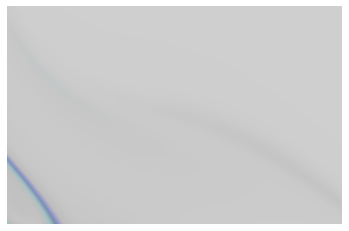

Generating image 1 took 4.51595664024353 seconds
Settings:
n_size: 13
n_depth: 11
colormode: rgb
alpha: True
z1: -0.72624
z2: -0.19368
--------
Generated image: 2


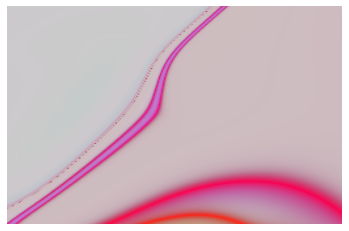

Generating image 2 took 4.032962322235107 seconds
Settings:
n_size: 14
n_depth: 10
colormode: bw
alpha: False
z1: 0.14255
z2: -0.38622
--------
Generated image: 3


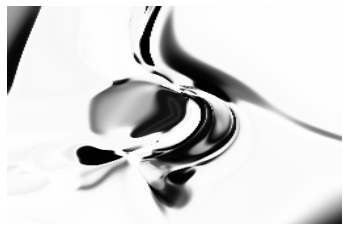

Generating image 3 took 3.508967638015747 seconds
Settings:
n_size: 12
n_depth: 12
colormode: rgb
alpha: True
z1: -0.39475
z2: -0.67197
--------
Generated image: 4


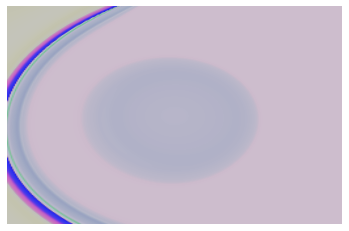

Generating image 4 took 4.089961051940918 seconds
Settings:
n_size: 12
n_depth: 12
colormode: hsl
alpha: True
z1: 0.95898
z2: -0.00935
--------
Generated image: 5


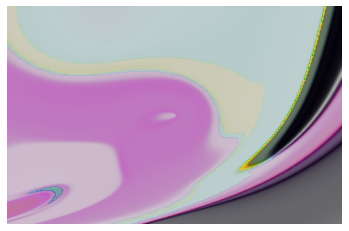

Generating image 5 took 4.7219579219818115 seconds
Settings:
n_size: 18
n_depth: 6
colormode: bw
alpha: False
z1: 0.30633
z2: 0.09442
--------
Generated image: 6


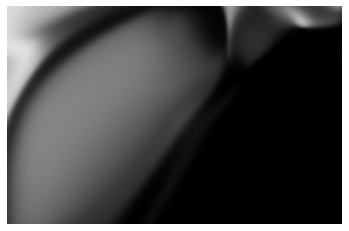

Generating image 6 took 2.670975923538208 seconds
Settings:
n_size: 19
n_depth: 5
colormode: bw
alpha: True
z1: 0.91837
z2: -0.34998
--------
Generated image: 7


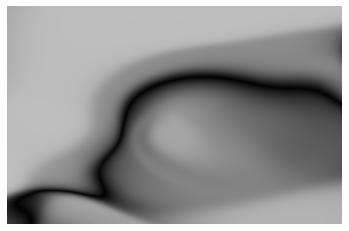

Generating image 7 took 2.580977201461792 seconds
Settings:
n_size: 15
n_depth: 9
colormode: hsl
alpha: True
z1: -0.385
z2: 0.92596
--------
Generated image: 8


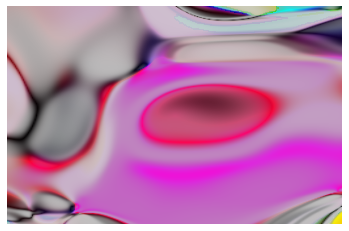

Generating image 8 took 4.372961521148682 seconds
Settings:
n_size: 18
n_depth: 6
colormode: bw
alpha: False
z1: 0.72774
z2: -0.89946
--------
Generated image: 9


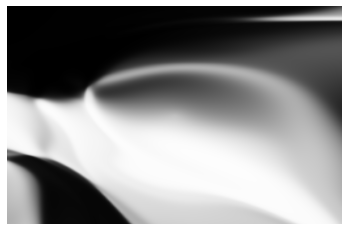

Generating image 9 took 2.6779751777648926 seconds
Settings:
n_size: 15
n_depth: 9
colormode: cmyk
alpha: True
z1: 0.14114
z2: 0.49769
--------
Generated image: 10


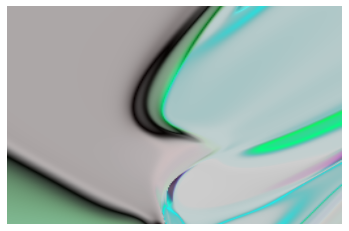

Generating image 10 took 3.770965099334717 seconds


In [15]:
for i in range(n_images):
    n_size, n_depth, colormode, alpha, z1, z2 = randomize_configs()
    print("Settings:")
    print("n_size: {}".format(n_size))
    print("n_depth: {}".format(n_depth))
    print("colormode: {}".format(colormode))
    print("alpha: {}".format(alpha))
    print("z1: {}".format(z1))
    print("z2: {}".format(z2))
    print("--------")
    fname = "nb_output/generated_{}_{}.png".format(colormode, i+1)
    print("Generated image: {}".format(i+1))
    start_time = time.time()
    generate_image(img_height, img_width, n_depth, n_size, activation, colormode, alpha, z1, z2,
                   show=True, nnet_dict=None, fname=fname, save=True)
    delta = time.time() - start_time
    print("Generating image {} took {} seconds".format(i+1, delta))

### Generate an image with defined network parameters ###
As mentioned one can define the hidden layer size and neurons within the hidden layers via the `layers` list.  
Make sure the first element of the `layers`-list is 5 (because of the 5 input values). Hence `layers[0] = 5`  
In case of `cmyk` colormode the output neuron size ought to be 4. Hence `layers[-1]=4`  
For all other colormodes `rgb, bw, hsv, hsl` the output neurons ought to be 3. Hence `layers[-1]=3`  
If the alpha channel should be used as well, the outputlayer needs to be imcremented by 1. Hence `layers[-1] +=1`

In [16]:
img_height = img_width = 512
colormode = "cmyk"
alpha = False
activations_fnc = ["tanh", "softsign", "identity", "tanh", "sigmoid"]
layers = [5, 10, 8, 18, 13, 4]
if alpha:
    layers[-1] += 1
nnet_dict = {"layers":layers, "activations_fnc":activations_fnc}
z1 = -0.99
z2 = 0.85

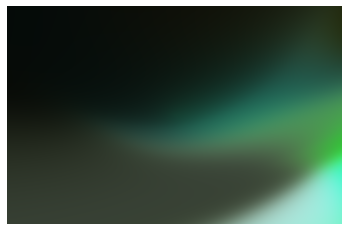

Generating image took 9.125910997390747 seconds


In [17]:
start_time = time.time()
generate_image(img_height=img_height, img_width=img_width,
               n_depth=None, n_size=None, activation=None,
               colormode=colormode, alpha=alpha, z1=z1, z2=z2,
               nnet_dict=nnet_dict,
               show=True, save=False)
delta = time.time() - start_time
print("Generating image took {} seconds".format(delta))

In [18]:
img_height = img_width = 512
colormode = "hsv"
alpha = True
activations_fnc = ["tanh", "softsign", "relu", "tanh", "sigmoid"]
layers = [5, 10, 20, 18, 25, 3]
if alpha:
    layers[-1] += 1
nnet_dict = {"layers":layers, "activations_fnc":activations_fnc}
z1 = -0.45
z2 = 0.66

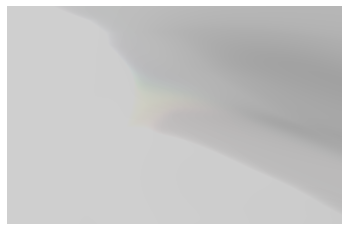

Generating image took 11.697889804840088 seconds


In [19]:
start_time = time.time()
generate_image(img_height=img_height, img_width=img_width,
               n_depth=None, n_size=None, activation=None,
               colormode=colormode, alpha=alpha, z1=z1, z2=z2,
               nnet_dict=nnet_dict,
               show=True, save=False)
delta = time.time() - start_time
print("Generating image took {} seconds".format(delta))

In [20]:
img_height = img_width = 512
colormode = "bw"
alpha = False
activations_fnc = ["tanh", "softsign", "softsign", "tanh", "sigmoid"]
layers = [5, 10, 30, 40, 50, 3]
if alpha:
    layers[-1] += 1
nnet_dict = {"layers":layers, "activations_fnc":activations_fnc}
z1 = 0.255
z2 = 0.900

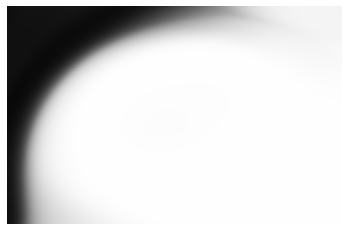

Generating image took 9.826904296875 seconds


In [21]:
start_time = time.time()
generate_image(img_height=img_height, img_width=img_width,
               n_depth=None, n_size=None, activation=None,
               colormode=colormode, alpha=alpha, z1=z1, z2=z2,
               nnet_dict=nnet_dict,
               show=True, save=False)
delta = time.time() - start_time
print("Generating image took {} seconds".format(delta))

In [22]:
img_height = img_width = 512
colormode = "hsl"
alpha = False
activations_fnc = ["tanh", "sin", "cos", "tanh", "sigmoid"]
layers = [5, 20, 10, 30, 40, 3]
if alpha:
    layers[-1] += 1
nnet_dict = {"layers":layers, "activations_fnc":activations_fnc}
z1 = 0.255
z2 = 0.900

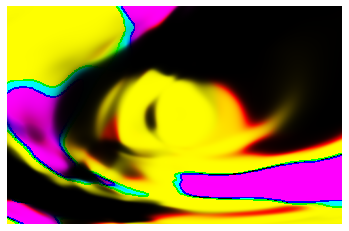

Generating image took 9.72290325164795 seconds


In [23]:
start_time = time.time()
generate_image(img_height=img_height, img_width=img_width,
               n_depth=None, n_size=None, activation=None,
               colormode=colormode, alpha=alpha, z1=z1, z2=z2,
               nnet_dict=nnet_dict,
               show=True, save=False)
delta = time.time() - start_time
print("Generating image took {} seconds".format(delta))

# End #